# Modeling II

## Nota: Legit (clase positiva), Phishing (clase negativa)

In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_validate
from utils import predicted_report, SEED, k_folds_evaluation
from sklearn.svm import SVC, LinearSVC
import scikitplot.plotters as skplt
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb

%matplotlib inline

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Vamos a probar ahora algunos modelos realizados en el apartado anterior pero con variantes. 

Probaremos los datos rebalanceados mediante técnicas más avanzadas, además de realizar PCA y/o LDA.
Estos métodos de rebalanceo son interesantes dado que se centran en eliminar observaciones poco informativas (OSS) o bien de eliminar ruido o aquellas observaciones cercanas a la frontera de separación entre clases (CNN), por lo que probaremos qué tal se comportan modelos que trabajan por debajo con hiperplanos (SVMs, por ejemplo) con estas técnicas de rebalanceo.

A continuación cargamos tanto los pliegues como los conjuntos de entrenamiento que son resultados de aplicar cada método.

In [47]:
with open('./rebalanced_data/k_folds_cnn.pickle', mode='rb') as f:
    k_folds_cnn = pickle.load(f)

In [48]:
with open('./rebalanced_data/train_set_cnn.pickle', mode='rb') as f:
    train_cnn = pickle.load(f)

In [38]:
with open('./rebalanced_data/k_folds_oss.pickle', mode='rb') as f:
    k_folds_oss = pickle.load(f)

In [39]:
with open('./rebalanced_data/train_set_oss.pickle', mode='rb') as f:
    train_oss = pickle.load(f)

## One Sided Selection

## XGBoost

In [40]:
tuned_parameters = {'n_estimators': np.array([10, 50, 70, 80, 90, 100]),
                    'max_depth': np.array([4, 8, 15]),
                    'learning_rate': np.array([0.1, 0.2, 0.5]),
                    'gamma': np.array([0.002, 0.005, 0.01]),
                    'max_delta_step': np.array([0, 0.001, 0.002]),
                    'colsample_bytree': np.array([5/len(train_sru['x'].columns), 
                                                  8/len(train_sru['x'].columns), 
                                                  10/len(train_sru['x'].columns)
                                                 ]), 
                    'colsample_bylevel': np.array([1, 0.5, 0.2]),
                    'reg_lambda': np.array([1, 0.5, 0])
                   }

gb = xgb.XGBClassifier(seed=SEED)

grid = GridSearchCV(gb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_oss[len(k_folds_oss)-1], 
                    n_jobs=-1,
                    scoring='precision') 

gb_fit = grid.fit(train_oss['x'], train_oss['y'])

In [41]:
gb_fit.best_params_

{'colsample_bylevel': 1.0,
 'colsample_bytree': 0.34482758620689657,
 'gamma': 0.01,
 'learning_rate': 0.5,
 'max_delta_step': 0.0,
 'max_depth': 8,
 'n_estimators': 70,
 'reg_lambda': 1.0}

In [42]:
gb_final = xgb.XGBClassifier(seed=SEED,
             n_estimators=gb_fit.best_params_['n_estimators'],
             max_depth=gb_fit.best_params_['max_depth'],
             learning_rate=gb_fit.best_params_['learning_rate'],
             gamma=gb_fit.best_params_['gamma'],
             max_delta_step=gb_fit.best_params_['max_delta_step'],
             colsample_bytree=gb_fit.best_params_['colsample_bytree'],
             colsample_bylevel=gb_fit.best_params_['colsample_bylevel'],
             reg_lambda=gb_fit.best_params_['reg_lambda']
            ).fit(train_oss['x'], train_oss['y'])

In [43]:
with open('./final_models/xgboost_oss_final.pickle', mode='wb') as f:
    pickle.dump(gb_final, f, protocol=4)

In [44]:
gb_validation_results = cross_validate(
                           gb_final,
                           train_oss['x'],
                           train_oss['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_oss[len(k_folds_oss)-1],
                           n_jobs=-1
                         )

In [45]:
k_folds_evaluation(gb_validation_results)

Accuracies: 
[ 0.9733711   0.96768707  0.97165533  0.96937039  0.95916052]
Mean accuracy: 
0.968 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.97593446  0.97066392  0.97425335  0.97213622  0.96292482]
Mean F1: 
0.971 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.97244898  0.97116375  0.97525773  0.97515528  0.96391753]
Mean precision: 
0.972 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.97944502  0.97016461  0.97325103  0.9691358   0.96193416]
Mean recall: 
0.971 (+/- 0.006)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### SVM: RBF

In [53]:
tuned_parameters = { 
                    'C': np.array([0.1, 0.5, 10, 100]),
                    'gamma': np.array([0.1, 2, 10, 100]),
                    'max_iter': np.array([-1])
                   }

rbf_svm = SVC(kernel='rbf', random_state=SEED, cache_size=2048)

grid = GridSearchCV(rbf_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_oss[len(k_folds_oss)-1], 
                    n_jobs=-1,
                    scoring='precision') 

rbf_svm_fit = grid.fit(train_oss['x'], train_oss['y'])

In [54]:
rbf_svm_fit.best_params_

{'C': 100.0, 'gamma': 0.10000000000000001, 'max_iter': -1}

In [55]:
rbf_svm_final = SVC(
                 C=rbf_svm_fit.best_params_['C'],
                 gamma=rbf_svm_fit.best_params_['gamma'],
                 max_iter=rbf_svm_fit.best_params_['max_iter'],
                 kernel='rbf', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(train_oss['x'], train_oss['y'])

In [56]:
with open('./final_models/rbf_svm_oss_final.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_final, f, protocol=4)

In [57]:
rbf_validation_results = cross_validate(
                           rbf_svm_final,                            
                           train_oss['x'],
                           train_oss['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_oss[len(k_folds_oss)-1],
                           n_jobs=-1
                         )

In [58]:
k_folds_evaluation(rbf_validation_results)

Accuracies: 
[ 0.96657224  0.96882086  0.97165533  0.9659671   0.96086217]
Mean accuracy: 
0.967 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.96994396  0.97180933  0.97446374  0.9692623   0.96477795]
Mean F1: 
0.970 (+/- 0.003)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.96161616  0.96833504  0.96754564  0.96530612  0.95744681]
Mean precision: 
0.964 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.97841727  0.97530864  0.98148148  0.97325103  0.97222222]
Mean recall: 
0.976 (+/- 0.003)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### SVM: Lineal

In [65]:
tuned_parameters = {'C': np.array([0.1, 0.5, 1, 10, 100]),                    
                    'loss':np.array(['hinge', 'squared_hinge']),
                    'max_iter': np.array([-1])
                   }

l_svm = LinearSVC(random_state=SEED, penalty='l2', dual=True)

grid = GridSearchCV(l_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_oss[len(k_folds_oss)-1], 
                    n_jobs=-1,
                    scoring='precision') 

l_svm_fit = grid.fit(train_oss['x'], train_oss['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaco

In [66]:
l_svm_fit.best_params_

{'C': 0.10000000000000001, 'loss': 'hinge', 'max_iter': -1}

In [68]:
lsvm_final = LinearSVC(
                 C=l_svm_fit.best_params_['C'],
                 loss=l_svm_fit.best_params_['loss'],
                 max_iter=l_svm_fit.best_params_['max_iter'],
                 penalty='l2',
                 dual=True
             ).fit(train_oss['x'], train_oss['y'])

In [69]:
with open('./final_models/lsvm_final_oss.pickle', mode='wb') as f:
    pickle.dump(lsvm_final, f, protocol=4)

In [70]:
lsvm_validation_results = cross_validate(
                           lsvm_final,                            
                           train_oss['x'],
                           train_oss['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_oss[len(k_folds_oss)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3

In [71]:
k_folds_evaluation(lsvm_validation_results)

Accuracies: 
[ 0.44872521  0.44897959  0.44897959  0.44866704  0.44866704]
Mean accuracy: 
0.449 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.  0.  0.  0.  0.]
Mean F1: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.  0.  0.  0.  0.]
Mean precision: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.  0.  0.  0.  0.]
Mean recall: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### SVM: Sigmoidal

In [91]:
tuned_parameters = { 
                    'C': np.array([0.01, 0.1, 0.5, 5, 10]),
                    'gamma': np.array([0.01, 0.1, 5, 10]),
                    'max_iter': np.array([-1])
                   }

sig_svm = SVC(kernel='sigmoid', random_state=SEED, cache_size=2048)

grid = GridSearchCV(sig_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_oss[len(k_folds_oss)-1], 
                    n_jobs=-1,
                    scoring='precision') 

sig_svm_fit = grid.fit(train_oss['x'], train_oss['y'])

In [93]:
sig_svm_fit.best_params_

{'C': 5.0, 'gamma': 0.01, 'max_iter': -1}

In [94]:
sig_svm_final = SVC(
                 C=sig_svm_fit.best_params_['C'],
                 gamma=sig_svm_fit.best_params_['gamma'],
                 max_iter=sig_svm_fit.best_params_['max_iter'],
                 kernel='sigmoid', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(train_oss['x'], train_oss['y'])

In [95]:
with open('./final_models/sig_svm_final_oss.pickle', mode='wb') as f:
    pickle.dump(sig_svm_final, f, protocol=4)

In [96]:
sig_validation_results = cross_validate(
                           sig_svm_final,                            
                           train_oss['x'],
                           train_oss['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_oss[len(k_folds_oss)-1],
                           n_jobs=-1
                         )

In [97]:
k_folds_evaluation(sig_validation_results)

Accuracies: 
[ 0.93087819  0.90702948  0.9314059   0.91491775  0.9166194 ]
Mean accuracy: 
0.920 (+/- 0.010)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.93807107  0.91750503  0.93823379  0.9244713   0.92564492]
Mean F1: 
0.929 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.92678034  0.8976378   0.93110436  0.90532544  0.91044776]
Mean precision: 
0.914 (+/- 0.013)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.94964029  0.9382716   0.94547325  0.94444444  0.94135802]
Mean recall: 
0.944 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


## Condensed Nearest Neighbour

## XGBoost

In [ ]:
tuned_parameters = {'n_estimators': np.array([10, 50, 70, 80, 90, 100]),
                    'max_depth': np.array([4, 8, 15]),
                    'learning_rate': np.array([0.1, 0.2, 0.5]),
                    'gamma': np.array([0.002, 0.005, 0.01]),
                    'max_delta_step': np.array([0, 0.001, 0.002]),
                    'colsample_bytree': np.array([5/len(train_sru['x'].columns), 
                                                  8/len(train_sru['x'].columns), 
                                                  10/len(train_sru['x'].columns)
                                                 ]), 
                    'colsample_bylevel': np.array([1, 0.5, 0.2]),
                    'reg_lambda': np.array([1, 0.5, 0])
                   }

gb = xgb.XGBClassifier(seed=SEED)

grid = GridSearchCV(gb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_cnn[len(k_folds_cnn)-1], 
                    n_jobs=-1,
                    scoring='precision') 

gb_fit = grid.fit(train_cnn['x'], train_cnn['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaco

In [55]:
gb_fit.best_params_

{'colsample_bylevel': 1.0,
 'colsample_bytree': 0.27586206896551724,
 'gamma': 0.002,
 'learning_rate': 0.10000000000000001,
 'max_delta_step': 0.0,
 'max_depth': 4,
 'n_estimators': 10,
 'reg_lambda': 1.0}

In [56]:
gb_final = xgb.XGBClassifier(seed=SEED,
             n_estimators=gb_fit.best_params_['n_estimators'],
             max_depth=gb_fit.best_params_['max_depth'],
             learning_rate=gb_fit.best_params_['learning_rate'],
             gamma=gb_fit.best_params_['gamma'],
             max_delta_step=gb_fit.best_params_['max_delta_step'],
             colsample_bytree=gb_fit.best_params_['colsample_bytree'],
             colsample_bylevel=gb_fit.best_params_['colsample_bylevel'],
             reg_lambda=gb_fit.best_params_['reg_lambda']
            ).fit(train_cnn['x'], train_cnn['y'])

In [57]:
with open('./final_models/xgboost_cnn_final.pickle', mode='wb') as f:
    pickle.dump(gb_final, f, protocol=4)

In [58]:
gb_validation_results = cross_validate(
                           gb_final,
                           train_cnn['x'],
                           train_cnn['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_cnn[len(k_folds_cnn)-1],
                           n_jobs=-1
                         )

In [59]:
k_folds_evaluation(gb_validation_results)

Accuracies: 
[ 0.85963115  0.85538462  0.83897436  0.83675565  0.83983573]
Mean accuracy: 
0.846 (+/- 0.009)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.40692641  0.37333333  0.24880383  0.23188406  0.25714286]
Mean F1: 
0.304 (+/- 0.072)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 1.  1.  1.  1.  1.]
Mean precision: 
1.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.25543478  0.2295082   0.1420765   0.13114754  0.14754098]
Mean recall: 
0.181 (+/- 0.051)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### SVM: RBF

In [51]:
tuned_parameters = { 
                    'C': np.array([0.1, 0.5, 5, 10, 50]),
                    'gamma': np.array([0.1, 0.2, 0.5, 2, 10]),
                    'max_iter': np.array([-1])
                   }

rbf_svm = SVC(kernel='rbf', random_state=SEED, cache_size=2048)

grid = GridSearchCV(rbf_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_cnn[len(k_folds_cnn)-1], 
                    n_jobs=-1,
                    scoring='precision') 

rbf_svm_fit = grid.fit(train_cnn['x'], train_cnn['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaco

In [52]:
rbf_svm_fit.best_params_

{'C': 10.0, 'gamma': 0.10000000000000001, 'max_iter': -1}

In [43]:
rbf_svm_final = SVC(
                 C=rbf_svm_fit.best_params_['C'],
                 gamma=rbf_svm_fit.best_params_['gamma'],
                 max_iter=rbf_svm_fit.best_params_['max_iter'],
                 kernel='rbf', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(train_cnn['x'], train_cnn['y'])

In [44]:
with open('./final_models/rbf_svm_cnn_final.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_final, f, protocol=4)

In [45]:
rbf_validation_results = cross_validate(
                           rbf_svm_final,                            
                           train_cnn['x'],
                           train_cnn['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_cnn[len(k_folds_cnn)-1],
                           n_jobs=-1
                         )

In [46]:
k_folds_evaluation(rbf_validation_results)

Accuracies: 
[ 0.94979508  0.94564103  0.93538462  0.91991786  0.89425051]
Mean accuracy: 
0.929 (+/- 0.020)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.86863271  0.85399449  0.82152975  0.77325581  0.69069069]
Mean F1: 
0.802 (+/- 0.064)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.85714286  0.86111111  0.85294118  0.82608696  0.76666667]
Mean precision: 
0.833 (+/- 0.035)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.88043478  0.84699454  0.79234973  0.72677596  0.6284153 ]
Mean recall: 
0.775 (+/- 0.090)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### SVM: Lineal

In [73]:
tuned_parameters = {'C': np.array([0.1, 0.5, 1, 10, 100]),                    
                    'loss':np.array(['hinge', 'squared_hinge']),
                    'max_iter': np.array([-1])
                   }

l_svm = LinearSVC(random_state=SEED, penalty='l2', dual=True)

grid = GridSearchCV(l_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_cnn[len(k_folds_cnn)-1], 
                    n_jobs=-1,
                    scoring='precision') 

l_svm_fit = grid.fit(train_cnn['x'], train_cnn['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaco

In [74]:
l_svm_fit.best_params_

{'C': 0.10000000000000001, 'loss': 'hinge', 'max_iter': -1}

In [75]:
lsvm_final = LinearSVC(
                 C=l_svm_fit.best_params_['C'],
                 loss=l_svm_fit.best_params_['loss'],
                 max_iter=l_svm_fit.best_params_['max_iter'],
                 penalty='l2',
                 dual=True
             ).fit(train_cnn['x'], train_cnn['y'])

In [76]:
with open('./final_models/lsvm_final_cnn.pickle', mode='wb') as f:
    pickle.dump(lsvm_final, f, protocol=4)

In [77]:
lsvm_validation_results = cross_validate(
                           lsvm_final,                            
                           train_cnn['x'],
                           train_cnn['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_cnn[len(k_folds_cnn)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/e

In [78]:
k_folds_evaluation(lsvm_validation_results, k_folds_cnn)

Accuracies: 
[ 0.81147541  0.81230769  0.81230769  0.81211499  0.81211499]
Mean accuracy: 
0.812 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.  0.  0.  0.  0.]
Mean F1: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.  0.  0.  0.  0.]
Mean precision: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.  0.  0.  0.  0.]
Mean recall: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### SVM: Sigmoidal

In [99]:
tuned_parameters = { 
                    'C': np.array([0.01, 0.1, 0.5, 5, 10]),
                    'gamma': np.array([0.01, 0.1, 5, 10]),
                    'max_iter': np.array([-1])
                   }

sig_svm = SVC(kernel='sigmoid', random_state=SEED, cache_size=2048)

grid = GridSearchCV(sig_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_cnn[len(k_folds_cnn)-1], 
                    n_jobs=-1,
                    scoring='precision') 

sig_svm_fit = grid.fit(train_cnn['x'], train_cnn['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaco

In [100]:
sig_svm_fit.best_params_

{'C': 0.10000000000000001, 'gamma': 0.01, 'max_iter': -1}

In [101]:
sig_svm_final = SVC(
                 C=sig_svm_fit.best_params_['C'],
                 gamma=sig_svm_fit.best_params_['gamma'],
                 max_iter=sig_svm_fit.best_params_['max_iter'],
                 kernel='sigmoid', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(train_cnn['x'], train_cnn['y'])

In [102]:
with open('./final_models/sig_svm_final_cnn.pickle', mode='wb') as f:
    pickle.dump(sig_svm_final, f, protocol=4)

In [103]:
sig_validation_results = cross_validate(
                           sig_svm_final,                            
                           train_cnn['x'],
                           train_cnn['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_cnn[len(k_folds_cnn)-1],
                           n_jobs=-1
                         )

In [104]:
k_folds_evaluation(sig_validation_results)

Accuracies: 
[ 0.8125      0.81846154  0.81435897  0.81827515  0.81930185]
Mean accuracy: 
0.817 (+/- 0.003)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.01081081  0.06349206  0.02162162  0.06349206  0.07368421]
Mean F1: 
0.047 (+/- 0.025)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 1.  1.  1.  1.  1.]
Mean precision: 
1.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.00543478  0.03278689  0.01092896  0.03278689  0.03825137]
Mean recall: 
0.024 (+/- 0.013)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Observaciones: Con estas dos técnicas de rebalanceo el tiempo de ejecución de los modelos SVM ha sido muy inferior que con un rebalanceo normal.

## PCA

El objeto de usar técnicas de reducción de la dimensionalidad es el de trabajar con características, de tal manera que la aplicación de los modelos sea más rápida pero igual de eficaz.

Para hacer PCA, trabajaremos con el conjunto de entrenamiento completo de un rembalanceo aleatorio simple.

In [4]:
with open('./rebalanced_data/k_folds_sru.pickle', mode='rb') as f:
    k_folds_sru = pickle.load(f)

In [5]:
with open('./rebalanced_data/train_set_sru.pickle', mode='rb') as f:
    train_sru = pickle.load(f)

In [6]:
pca = PCA(n_components='mle', svd_solver='full', whiten=True, random_state=SEED)
pca.fit(train_sru['x'])

PCA(copy=True, iterated_power='auto', n_components='mle',
  random_state=16121993, svd_solver='full', tol=0.0, whiten=True)

In [22]:
with open('./final_models/pca.pickle', mode='wb') as f:
    pickle.dump(pca, f, protocol=4)

Ratio de varianza explicada por cada componente: 
[ 0.15639307  0.12012543  0.11186352  0.06771935  0.06562649  0.0568383
  0.04495465  0.03935169  0.03781959  0.03261204  0.03136426  0.02819612
  0.02683552  0.02411618  0.02216033  0.0215081   0.01719166  0.01532396
  0.01436581  0.0131533   0.01129051  0.00913029  0.00817958  0.00619065
  0.00462862  0.00405268  0.00389725  0.00324488]


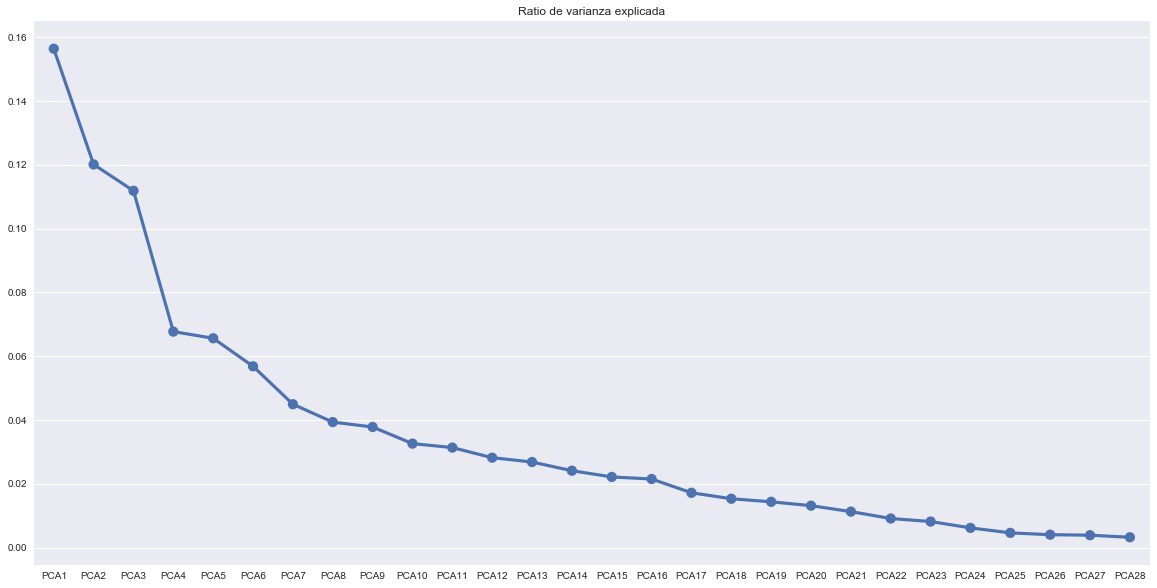


Ratio acumulado de varianza explicada: 
[ 0.15639307  0.2765185   0.38838203  0.45610137  0.52172786  0.57856616
  0.62352081  0.6628725   0.7006921   0.73330414  0.7646684   0.79286453
  0.81970005  0.84381622  0.86597656  0.88748465  0.90467632  0.92000027
  0.93436609  0.94751938  0.95880989  0.96794018  0.97611975  0.9823104
  0.98693903  0.99099171  0.99488895  0.99813383]


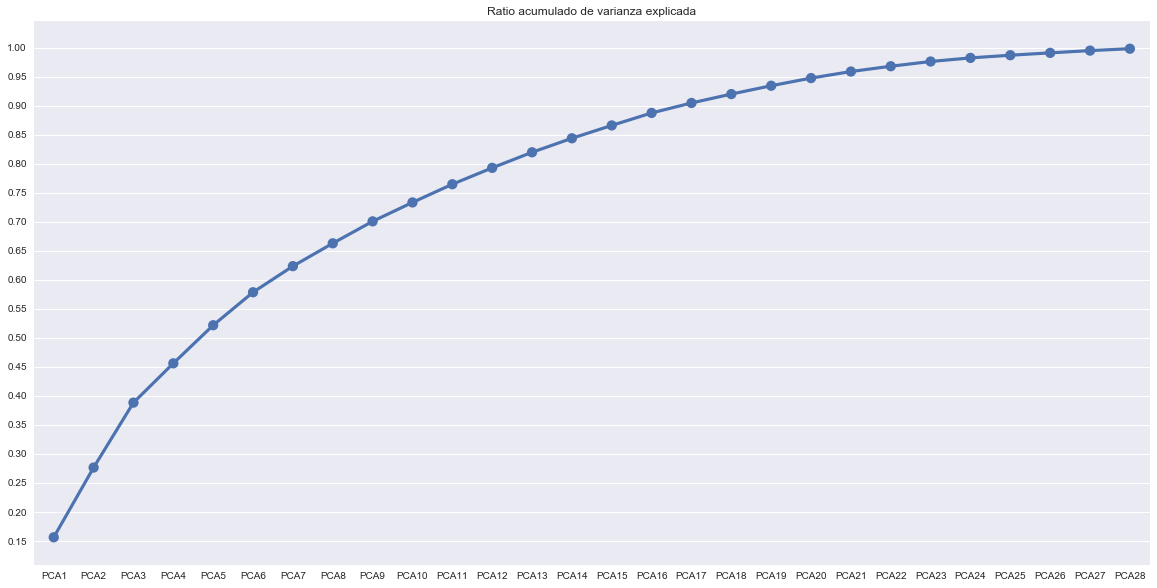

In [45]:
print('Ratio de varianza explicada por cada componente: ')
print(pca.explained_variance_ratio_)
sns.plt.figure(figsize=(20, 10))
sns.pointplot(x=['PCA%i' % i for i in list(range(1,len(pca.explained_variance_ratio_)+1))], 
              y=pca.explained_variance_ratio_)
sns.plt.title('Ratio de varianza explicada')
sns.plt.show()


print('\nRatio acumulado de varianza explicada: ')
accumulated_var = np.cumsum(pca.explained_variance_ratio_)
print(accumulated_var)
sns.plt.figure(figsize=(20, 10))
fig = sns.pointplot(x=['PCA%i' % i for i in list(range(1,len(pca.explained_variance_ratio_)+1))], 
              y=accumulated_var)
fig.get_yaxis().set_major_locator(ticker.MultipleLocator(0.05))
sns.plt.title('Ratio acumulado de varianza explicada')
sns.plt.show()

Los resultados del PCA no parecen ser los mejores, dado que habría que seleccionar 17 componentes para explicar el 90% de la varianza. Aún así, los modelos usarían 11 features menos.

## LDA

Podemos probar sus capacidades tanto de transformación como de clasificación.

#### Transformación (El resultado es una sóla feature dado que se consiguen número de clases - 1 features.):

In [35]:
lda = LinearDiscriminantAnalysis(solver='svd')
lda.fit(train_sru['x'], train_sru['y'])
lda_x = lda.transform(train_sru['x'])

In [34]:
with open('./final_models/lda.pickle', mode='wb') as f:
    pickle.dump(lda, f, protocol=4)

In [138]:
lda.explained_variance_ratio_

array([ 1.])

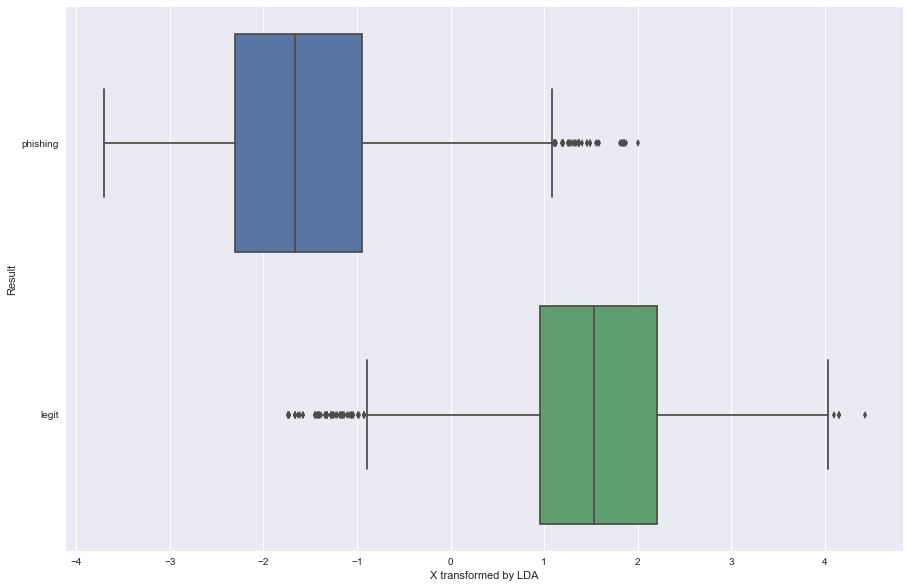

In [184]:
results_to_vals = np.vectorize(lambda x: 'legit' if x == 1 else 'phishing')

sns.plt.figure(figsize=(15, 10))
fig = sns.boxplot(x='x', 
                  y='y', 
                  data=pd.DataFrame({'x': lda_x.flatten(), 'y':results_to_vals(train_sru['y'])}, columns=['x', 'y'])
           )
fig.set(xlabel='X transformed by LDA', ylabel='Result')
sns.plt.show()

#### Predicción:

In [186]:
predicted_report(results_to_vals(train_sru['y']), results_to_vals(lda.predict(train_sru['x'])))  

Predicted  legit  phishing   All
Actual                          
legit       3709       249  3958
phishing     405      3553  3958
All         4114      3802  7916

Accuracy: 0.917383

             precision    recall  f1-score   support

      legit       0.90      0.94      0.92      3958
   phishing       0.93      0.90      0.92      3958

avg / total       0.92      0.92      0.92      7916



Parece que los resultados son buenos si realizamos la comprobación en el propio conjunto de entrenamiento. Vamos a comprobar qué tal se comporta particionando el conjunto de entrenamiento en 5 partes.

In [201]:
lda_validation_results = cross_validate(
                           lda,                            
                           train_sru['x'],
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

In [202]:
k_folds_evaluation(lda_validation_results)

Accuracies: 
[ 0.92992424  0.91098485  0.9280303   0.90328698  0.91213654]
Mean accuracy: 
0.917 (+/- 0.010)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.93092719  0.91354997  0.92901619  0.90514569  0.91382517]
Mean F1: 
0.918 (+/- 0.010)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.91779141  0.88796186  0.91646192  0.88807786  0.89659367]
Mean precision: 
0.901 (+/- 0.013)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.94444444  0.94065657  0.94191919  0.92288243  0.93173198]
Mean recall: 
0.936 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Ahora lo que podemos comprobar es si con PCA y LDA se obtienen los mismos resultados (o mejores) con algunos de los modelos ya probados. También es interesante considerar el tiempo de ejecución aunque haya una pequeña penalización en las métricas de clasificación.

- Multinomial Naïve Bayes (A ver si mejora)
- XGBoost (A ver si empeora o no)
- SVM RBF (A ver si mejora)
- SVM Polynomial (A ver si empeora o no)

LDA

Multinomial Naïve Bayes

In [226]:
x_nb = lda_x + 4 # Los datos de entrada no pueden ser negativos
y_nb = np.array([1 if x==1 else 0 for x in list(train_sru['y'])])

tuned_parameters = {'alpha': np.linspace(0, 1, 20) # Pag. 20 http://classes.engr.oregonstate.edu/eecs/winter2011/cs434/notes/bayes-6.pdf
                   }

mnb = MultinomialNB(fit_prior=True)

grid = GridSearchCV(mnb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

mnb_fit = grid.fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will

In [221]:
mnb_fit.best_params_

{'alpha': 0.0}

In [222]:
mnb_final = MultinomialNB(
             alpha=mnb_fit.best_params_['alpha'],
             fit_prior=True
            ).fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [223]:
mnb_validation_results = cross_validate(
                           mnb_final, 
                           x_nb,
                           y_nb, 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will r

In [224]:
k_folds_evaluation(mnb_validation_results)

Accuracies: 
[ 0.5  0.5  0.5  0.5  0.5]
Mean accuracy: 
0.500 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.  0.  0.  0.  0.]
Mean F1: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.  0.  0.  0.  0.]
Mean precision: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.  0.  0.  0.  0.]
Mean recall: 
0.000 (+/- 0.000)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


XGBoost

In [24]:
tuned_parameters = {'n_estimators': np.array([10, 50, 70, 80, 90, 100]),
                    'max_depth': np.array([4, 8, 15]),
                    'learning_rate': np.array([0.1, 0.2, 0.5]),
                    'gamma': np.array([0.002, 0.005, 0.01]),
                    'max_delta_step': np.array([0, 0.001, 0.002]), 
                    'reg_lambda': np.array([1, 0.5, 0])
                   }

gb = xgb.XGBClassifier(seed=SEED)

grid = GridSearchCV(gb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

gb_fit = grid.fit(lda_x, train_sru['y'])

In [26]:
with open('./gs_models/xgb_fit_lda_sru.pickle', mode='wb') as f:
    pickle.dump(gb_fit, f, protocol=4)

In [25]:
gb_fit.best_params_

{'gamma': 0.0050000000000000001,
 'learning_rate': 0.5,
 'max_delta_step': 0.0,
 'max_depth': 15,
 'n_estimators': 70,
 'reg_lambda': 0.0}

In [28]:
gb_final = xgb.XGBClassifier(seed=SEED,
             n_estimators=gb_fit.best_params_['n_estimators'],
             max_depth=gb_fit.best_params_['max_depth'],
             learning_rate=gb_fit.best_params_['learning_rate'],
             gamma=gb_fit.best_params_['gamma'],
             max_delta_step=gb_fit.best_params_['max_delta_step'],
             reg_lambda=gb_fit.best_params_['reg_lambda']
            ).fit(lda_x, train_sru['y'])

In [32]:
with open('./final_models/gb_final_lda_sru.pickle', mode='wb') as f:
    pickle.dump(gb_final, f, protocol=4)

In [31]:
gb_validation_results = cross_validate(
                           gb_final,
                           lda_x,
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

In [32]:
k_folds_evaluation(gb_validation_results)

Accuracies: 
[ 0.94444444  0.93371212  0.94444444  0.93678887  0.94310999]
Mean accuracy: 
0.940 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.94444444  0.9339207   0.94472362  0.9369483   0.94332494]
Mean F1: 
0.941 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.94444444  0.93099122  0.94        0.93459119  0.93977415]
Mean precision: 
0.938 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.94444444  0.93686869  0.94949495  0.93931732  0.94690265]
Mean recall: 
0.943 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


SVM RBF

In [238]:
tuned_parameters = { 
                    'C': np.array([0.1, 0.5, 10, 100]),
                    'gamma': np.array([0.1, 10, 100]),
                    'max_iter': np.array([-1])
                   }

rbf_svm = SVC(kernel='rbf', random_state=SEED, cache_size=2048)

grid = GridSearchCV(rbf_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

rbf_svm_fit = grid.fit(lda_x, train_sru['y'])

In [244]:
with open('./gs_models/rbf_svm_fit_lda_sru.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_fit, f, protocol=4)

In [239]:
rbf_svm_fit.best_params_

{'C': 100.0, 'gamma': 10.0, 'max_iter': -1}

In [240]:
rbf_svm_final = SVC(
                 C=rbf_svm_fit.best_params_['C'],
                 gamma=rbf_svm_fit.best_params_['gamma'],
                 max_iter=rbf_svm_fit.best_params_['max_iter'],
                 kernel='rbf', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(lda_x, train_sru['y'])

In [245]:
with open('./final_models/rbf_svm_final_lda_sru.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_final, f, protocol=4)

In [241]:
rbf_validation_results = cross_validate(
                           rbf_svm_final,                            
                           lda_x,
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

In [242]:
k_folds_evaluation(rbf_validation_results)

Accuracies: 
[ 0.92992424  0.91161616  0.92361111  0.90707965  0.91340076]
Mean accuracy: 
0.917 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.92898273  0.91161616  0.9221865   0.90713834  0.91356467]
Mean F1: 
0.917 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.94163424  0.91161616  0.93971166  0.90656566  0.91183879]
Mean precision: 
0.922 (+/- 0.015)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.91666667  0.91161616  0.90530303  0.90771176  0.91529709]
Mean recall: 
0.911 (+/- 0.004)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


SVM Polinomial

In [17]:
tuned_parameters = {'degree': np.array([2, 3, 5, 10]), 
                    'C': np.array([0.1, 1, 10, 11, 100]),
                    'coef0': np.array([0, 10, 99, 100, 101]),
                    'gamma': np.array([0, 10, 99, 100, 101]),
                    'max_iter': np.array([5000])
                   }

poly_svm = SVC(kernel='poly', random_state=SEED, cache_size=2048)

grid = GridSearchCV(poly_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

poly_svm_fit = grid.fit(lda_x, train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

In [18]:
with open('./gs_models/poly_svm_fit_lda_sru.pickle', mode='wb') as f:
    pickle.dump(poly_svm_fit, f, protocol=4)

In [19]:
poly_svm_fit.best_params_

{'C': 0.10000000000000001,
 'coef0': 10,
 'degree': 2,
 'gamma': 10,
 'max_iter': 5000}

In [20]:
poly_svm_final = SVC(
                     degree=poly_svm_fit.best_params_['degree'],
                     C=poly_svm_fit.best_params_['C'],
                     coef0=poly_svm_fit.best_params_['coef0'],
                     gamma=poly_svm_fit.best_params_['gamma'],
                     max_iter=poly_svm_fit.best_params_['max_iter'],
                     kernel='poly', 
                     random_state=SEED, 
                     cache_size=2048
                 ).fit(lda_x, train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [21]:
with open('./final_models/poly_svm_final_lda_sru.pickle', mode='wb') as f:
    pickle.dump(poly_svm_final, f, protocol=4)

In [22]:
poly_validation_results = cross_validate(
                           poly_svm_final,                            
                           lda_x,
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

In [23]:
k_folds_evaluation(poly_validation_results)

Accuracies: 
[ 0.79482323  0.90467172  0.92613636  0.90707965  0.77180784]
Mean accuracy: 
0.861 (+/- 0.064)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.75285171  0.90941812  0.92436975  0.90829694  0.74808095]
Mean F1: 
0.849 (+/- 0.080)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.94646272  0.86628571  0.94701987  0.89655172  0.83489097]
Mean precision: 
0.898 (+/- 0.044)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.625       0.95707071  0.90277778  0.92035398  0.67762326]
Mean recall: 
0.817 (+/- 0.137)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


PCA

In [7]:
pca_x = [row[:-11] for row in pca.transform(train_sru['x'])]

Multinomial Naïve Bayes

In [49]:
x_nb = [x  + 4 for x in pca_x] # Los datos de entrada no pueden ser negativos
y_nb = np.array([1 if x==1 else 0 for x in list(train_sru['y'])])

tuned_parameters = {'alpha': np.linspace(0, 1, 20) # Pag. 20 http://classes.engr.oregonstate.edu/eecs/winter2011/cs434/notes/bayes-6.pdf
                   }

mnb = MultinomialNB(fit_prior=True)

grid = GridSearchCV(mnb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

mnb_fit = grid.fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting 

In [50]:
mnb_fit.best_params_

{'alpha': 0.0}

In [51]:
mnb_final = MultinomialNB(
             alpha=mnb_fit.best_params_['alpha'],
             fit_prior=True
            ).fit(x_nb, y_nb)

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [54]:
with open('./final_models/mnb_final_pca_sru.pickle', mode='wb') as f:
    pickle.dump(mnb_final, f, protocol=4)

In [52]:
mnb_validation_results = cross_validate(
                           mnb_final, 
                           x_nb,
                           y_nb, 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [53]:
k_folds_evaluation(mnb_validation_results)

Accuracies: 
[ 0.92487374  0.89962121  0.91666667  0.8931732   0.90518331]
Mean accuracy: 
0.908 (+/- 0.011)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.9258567   0.9025138   0.9175      0.89496582  0.90671642]
Mean F1: 
0.910 (+/- 0.011)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.91389914  0.8772348   0.90841584  0.8801956   0.89228886]
Mean precision: 
0.894 (+/- 0.015)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.93813131  0.92929293  0.92676768  0.9102402   0.9216182 ]
Mean recall: 
0.925 (+/- 0.009)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


XGBoost

In [63]:
tuned_parameters = {'n_estimators': np.array([10, 50, 70, 80, 90, 100]),
                    'max_depth': np.array([4, 8, 15]),
                    'learning_rate': np.array([0.1, 0.2, 0.5]),
                    'gamma': np.array([0.002, 0.005, 0.01]),
                    'max_delta_step': np.array([0, 0.001, 0.002]), 
                    'reg_lambda': np.array([1, 0.5, 0])
                   }

gb = xgb.XGBClassifier(seed=SEED)

grid = GridSearchCV(gb, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

gb_fit = grid.fit(np.array(pca_x), train_sru['y'])

In [64]:
with open('./gs_models/xgb_fit_pca_sru.pickle', mode='wb') as f:
    pickle.dump(gb_fit, f, protocol=4)

In [65]:
gb_fit.best_params_

{'gamma': 0.0050000000000000001,
 'learning_rate': 0.5,
 'max_delta_step': 0.0,
 'max_depth': 4,
 'n_estimators': 90,
 'reg_lambda': 0.0}

In [ ]:
gb_final = xgb.XGBClassifier(seed=SEED,
             n_estimators=gb_fit.best_params_['n_estimators'],
             max_depth=gb_fit.best_params_['max_depth'],
             learning_rate=gb_fit.best_params_['learning_rate'],
             gamma=gb_fit.best_params_['gamma'],
             max_delta_step=gb_fit.best_params_['max_delta_step'],
             reg_lambda=gb_fit.best_params_['reg_lambda']
            ).fit(np.array(pca_x), train_sru['y'])

In [26]:
with open('./final_models/gb_final_pca_sru.pickle', mode='wb') as f:
    pickle.dump(gb_final, f, protocol=4)

In [69]:
gb_validation_results = cross_validate(
                           gb_final,
                           np.array(pca_x),
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

In [70]:
k_folds_evaluation(gb_validation_results)

Accuracies: 
[ 0.97285354  0.9665404   0.96212121  0.96333755  0.95764855]
Mean accuracy: 
0.965 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.97280202  0.96677116  0.96202532  0.96315121  0.95746032]
Mean F1: 
0.964 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.97465146  0.96014944  0.96446701  0.96807152  0.96173469]
Mean precision: 
0.966 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.9709596   0.97348485  0.95959596  0.95828066  0.95322377]
Mean recall: 
0.963 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


SVM RBF

In [8]:
tuned_parameters = { 
                    'C': np.array([0.1, 0.5, 10, 100]),
                    'gamma': np.array([0.1, 10, 100]),
                    'max_iter': np.array([-1])
                   }

rbf_svm = SVC(kernel='rbf', random_state=SEED, cache_size=2048)

grid = GridSearchCV(rbf_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

rbf_svm_fit = grid.fit(np.array(pca_x), train_sru['y'])

In [9]:
with open('./gs_models/rbf_svm_fit_pca_sru.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_fit, f, protocol=4)

In [10]:
rbf_svm_fit.best_params_

{'C': 0.10000000000000001, 'gamma': 10.0, 'max_iter': -1}

In [11]:
rbf_svm_final = SVC(
                 C=rbf_svm_fit.best_params_['C'],
                 gamma=rbf_svm_fit.best_params_['gamma'],
                 max_iter=rbf_svm_fit.best_params_['max_iter'],
                 kernel='rbf', 
                 random_state=SEED, 
                 cache_size=2048
               ).fit(np.array(pca_x), train_sru['y'])

In [12]:
with open('./final_models/rbf_svm_final_pca_sru.pickle', mode='wb') as f:
    pickle.dump(rbf_svm_final, f, protocol=4)

In [13]:
rbf_validation_results = cross_validate(
                           rbf_svm_final,                            
                           np.array(pca_x),
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

In [14]:
k_folds_evaluation(rbf_validation_results)

Accuracies: 
[ 0.59090909  0.59911616  0.59217172  0.59860936  0.66055626]
Mean accuracy: 
0.608 (+/- 0.026)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.30916844  0.3308746   0.31422505  0.3308746   0.48905804]
Mean F1: 
0.355 (+/- 0.068)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.99315068  1.          0.98666667  0.99367089  0.98846154]
Mean precision: 
0.992 (+/- 0.005)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.18308081  0.19823232  0.18686869  0.19848293  0.32490518]
Mean recall: 
0.218 (+/- 0.054)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


SVM Polinomial

In [15]:
tuned_parameters = {'degree': np.array([2, 3, 5, 10]), 
                    'C': np.array([0.1, 1, 10, 11, 100]),
                    'coef0': np.array([0, 10, 99, 100, 101]),
                    'gamma': np.array([0, 10, 99, 100, 101]),
                    'max_iter': np.array([5000])
                   }

poly_svm = SVC(kernel='poly', random_state=SEED, cache_size=2048)

grid = GridSearchCV(poly_svm, 
                    param_grid=tuned_parameters, 
                    cv=k_folds_sru[len(k_folds_sru)-1], 
                    n_jobs=-1,
                    scoring='precision') 

poly_svm_fit = grid.fit(np.array(pca_x), train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

In [16]:
with open('./gs_models/poly_svm_fit_pca_sru.pickle', mode='wb') as f:
    pickle.dump(poly_svm_fit, f, protocol=4)

In [17]:
poly_svm_fit.best_params_

{'C': 0.10000000000000001,
 'coef0': 10,
 'degree': 5,
 'gamma': 10,
 'max_iter': 5000}

In [18]:
poly_svm_final = SVC(
                     degree=poly_svm_fit.best_params_['degree'],
                     C=poly_svm_fit.best_params_['C'],
                     coef0=poly_svm_fit.best_params_['coef0'],
                     gamma=poly_svm_fit.best_params_['gamma'],
                     max_iter=poly_svm_fit.best_params_['max_iter'],
                     kernel='poly', 
                     random_state=SEED, 
                     cache_size=2048
                 ).fit(np.array(pca_x), train_sru['y'])

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [19]:
with open('./final_models/poly_svm_final_pca_sru.pickle', mode='wb') as f:
    pickle.dump(poly_svm_final, f, protocol=4)

In [20]:
poly_validation_results = cross_validate(
                           poly_svm_final,                            
                           np.array(pca_x),
                           train_sru['y'], 
                           scoring=['accuracy', 'f1', 'precision', 'recall'], 
                           cv=k_folds_sru[len(k_folds_sru)-1],
                           n_jobs=-1
                         )

/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/jose/anaconda3/envs/intro/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.ma

In [21]:
k_folds_evaluation(poly_validation_results)

Accuracies: 
[ 0.96464646  0.94570707  0.94760101  0.95828066  0.95322377]
Mean accuracy: 
0.954 (+/- 0.007)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
F1 values: 
[ 0.96477987  0.94577554  0.94750158  0.95806861  0.95369212]
Mean F1: 
0.954 (+/- 0.007)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Precisions: 
[ 0.96115288  0.94458438  0.94930292  0.96296296  0.94423792]
Mean precision: 
0.952 (+/- 0.008)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Recalls: 
[ 0.96843434  0.9469697   0.94570707  0.95322377  0.96333755]
Mean recall: 
0.956 (+/- 0.009)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
